In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
!pip install streamlit
import streamlit as st
!pip install scikeras
import plotly.graph_objects as go
import ipywidgets as widgets
import plotly.express as px
from IPython.display import display
import matplotlib.ticker as mtick

# **Preprocessing**

In [7]:
# Run DonorProfile
df = pd.read_csv("DonorProfile.csv")
df.head()

,Donation Indicator,Donation Frequency,Average Donation,Digital Engagement Score,Last Donation Recency,Donation Amount Predicted,Wealth Index,Event Participation,DonorID,axio_segment_number
0,True,9,117.82,84,1,177.18,78,Medium,0,0
1,True,6,136.37,74,0,159.33,51,High,1,0
2,True,7,118.78,72,2,109.20,77,High,2,0
3,True,7,148.97,83,1,250.77,25,High,3,0
4,True,6,118.62,87,2,172.74,72,Medium,4,0


In [8]:
# Preprocessing

# 1. TRUE/FALSE → binary
df['Donation Indicator'] = df['Donation Indicator'].map({True: 1, False: 0})

# 2. Event Participation → number
df['Event Participation'] = df['Event Participation'].map({'None': 0, 'Low': 1, 'Medium': 2, 'High': 3})

# 3. axio_segment_number → int
df['axio_segment_number'] = df['axio_segment_number'].astype(int)
df.head()

,Donation Indicator,Donation Frequency,Average Donation,Digital Engagement Score,Last Donation Recency,Donation Amount Predicted,Wealth Index,Event Participation,DonorID,axio_segment_number
0,1,9,117.82,84,1,177.18,78,2.0,0,0
1,1,6,136.37,74,0,159.33,51,3.0,1,0
2,1,7,118.78,72,2,109.20,77,3.0,2,0
3,1,7,148.97,83,1,250.77,25,3.0,3,0
4,1,6,118.62,87,2,172.74,72,2.0,4,0


In [9]:
# Build the segment map
segment_map = {
    0: "Super Loyal Donors",
    1: "High-Potential Regulars",
    2: "Engaged Mid-tier Donors",
    3: "Modest Donors",
    4: "Returning Donors",
    5: "Recent First-time Donors",
    6: "Digital-Engaged Non-Donors",
    7: "Interested Non-Donors",
    8: "Event-Only Non-Donors",
    9: "Infrequent Low-Value Donors",
    10: "Lapsed Donors",
    11: "Passive Non-Engaged",
    12: "Wealthy Non-Donors",
    13: "High-Impact Infrequent Donors",
    14: "Fully Disengaged"
}
joblib.dump(segment_map, "segment_map.pkl")

['segment_map.pkl']

In [10]:
# Build a strategy map
strategy_map = {
    "Super Loyal Donors": "Cultivate deeper relationships to sustain contributions",
    "High-Potential Regulars": "Encourage incremental upsell and consistency",
    "Engaged Mid-tier Donors": "Maintain steady support and nurture deeper loyalty",
    "Modest Donors": "Encourage them to increase donation size or frequency",
    "Returning Donors": "Strengthen renewed relationship with targeted outreach",
    "Recent First-time Donors": "Nurture into repeat donors with welcome campaigns",
    "Digital-Engaged Non-Donors": "Convert engaged prospects into first-time donors",
    "Interested Non-Donors": "Encourage a first donation with targeted appeals",
    "Event-Only Non-Donors": "Convert event enthusiasm into donation behavior",
    "Infrequent Low-Value Donors": "Increase donation consistency and average gift size",
    "Lapsed Donors": "Reactivate by highlighting past impact and new initiatives",
    "Passive Non-Engaged": "Attempt basic awareness campaigns to prompt engagement",
    "Wealthy Non-Donors": "Targeted philanthropic messaging to inspire initial giving",
    "High-Impact Infrequent Donors": "Encourage them to donate more frequently or set recurring gifts",
    "Fully Disengaged": "Final attempt to reach or confirm removal"
}
joblib.dump(strategy_map, "strategy_map.pkl")

['strategy_map.pkl']

In [11]:
# Segment data
df["Total Donation"] = df["Average Donation"] * df["Donation Frequency"]
df["Donation Amount Predicted (Annual)"] = df["Donation Amount Predicted"] * df["Donation Frequency"]
df["Segment_Name"] = df["axio_segment_number"].map(segment_map)
summary = df.groupby("Segment_Name").agg(
    Donor_Count=("DonorID", "count"),
    Total_Donation_This_Year=("Total Donation", "sum"),
    Total_Predicted_Donation_Next_Year=("Donation Amount Predicted (Annual)", "sum")).reset_index()

In [12]:
summary

,Segment_Name,Donor_Count,Total_Donation_This_Year,Total_Predicted_Donation_Next_Year
0,Digital-Engaged Non-Donors,8000,2517610.59,5060829.49
1,Engaged Mid-tier Donors,10000,1464175.32,5410044.83
2,Event-Only Non-Donors,5000,1116421.13,1108898.98
3,Fully Disengaged,5000,847371.17,896021.08
4,High-Impact Infrequent Donors,8000,4130380.90,4240247.45
5,High-Potential Regulars,7000,4000584.25,5398924.47
6,Infrequent Low-Value Donors,7000,1168926.03,1248551.63
7,Interested Non-Donors,5000,2876871.56,2859538.29
8,Lapsed Donors,10000,1712373.77,1806492.83
9,Modest Donors,5000,855622.01,921244.01


In [13]:
print("Total Predicted Donation Next Year After Marketing", summary['Total_Predicted_Donation_Next_Year'].sum())
print("Total Donation This Year", summary['Total_Donation_This_Year'].sum())

Total Predicted Donation Next Year After Marketing 42778744.11
Total Donation This Year 32883016.34


In [44]:
# Segment Distribution
segment_counts = df['axio_segment_number'].value_counts()
segment_df = segment_counts.reset_index()
segment_df.columns = ['Segment', 'Count']
segment_counts

,count
axio_segment_number,
2,10000
10,10000
6,8000
12,8000
13,8000
9,7000
1,7000
11,7000
4,5000


In [14]:
# Segment Distribution
colors = [
    "#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A",
    "#19D3F3", "#FF6692", "#B6E880", "#FF97FF", "#FECB52",
    "#A1CAF1", "#D62728", "#2CA02C", "#9467BD", "#8C564B"
]
fig = go.Figure()

# Pie Chart
fig.add_trace(go.Pie(
    labels=summary["Segment_Name"].astype(str),
    values=summary["Donor_Count"],
    title="Donor Count by Segment",
    domain={'x': [0, 0.48]},
    hole=0.4,
    marker=dict(colors=colors)
))

# Bar Chart
fig.add_trace(go.Bar(
    x=segment_df['Segment'].astype(str),
    y=segment_df['Count'],
    name='Segment Count',
    marker_color=colors[:len(segment_df)],
    xaxis='x2',
    yaxis='y2'
))

# Layout
fig.update_layout(
    title_text="Segment Distribution Dashboard",
    grid=dict(rows=1, columns=2),
    height=500,
    width=1000,
    showlegend=False,
    xaxis2=dict(domain=[0.55, 1.0], title="Segment"),
    yaxis2=dict(title="Count")
)

fig.show()

# **EDA**

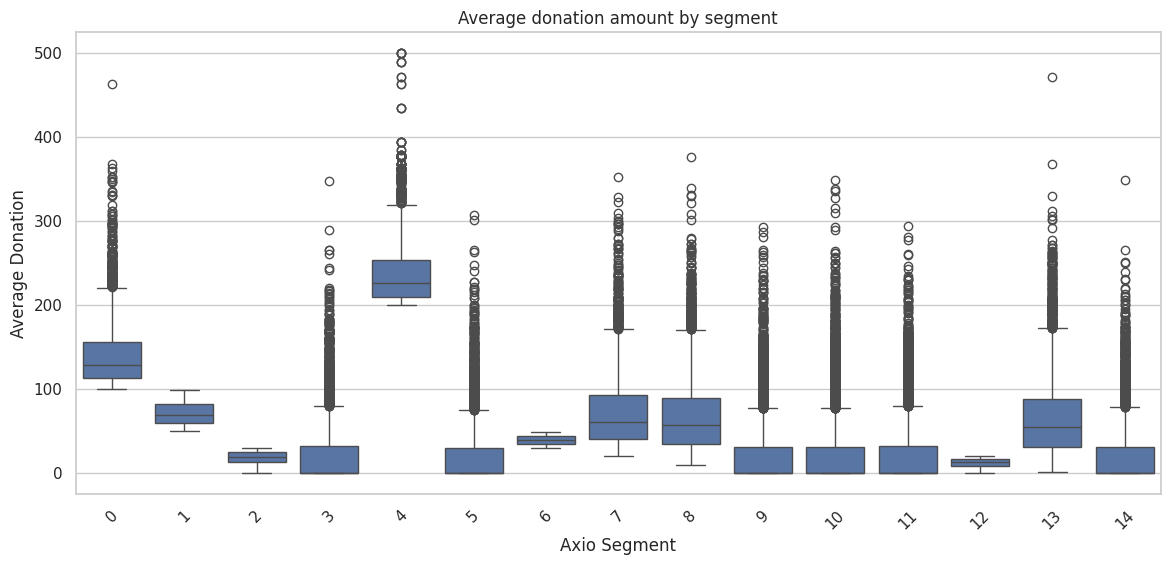

In [15]:
# Average distribution of contributions across segments
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
sns.boxplot(x='axio_segment_number', y='Average Donation', data=df)
plt.title("Average donation amount by segment")
plt.xlabel("Axio Segment")
plt.ylabel("Average Donation")
plt.xticks(rotation=45)
plt.show()

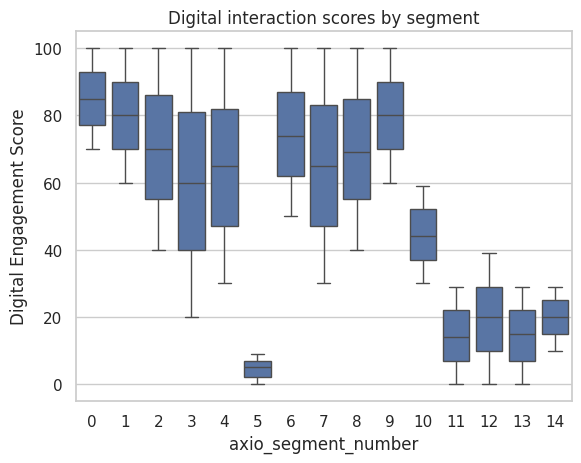

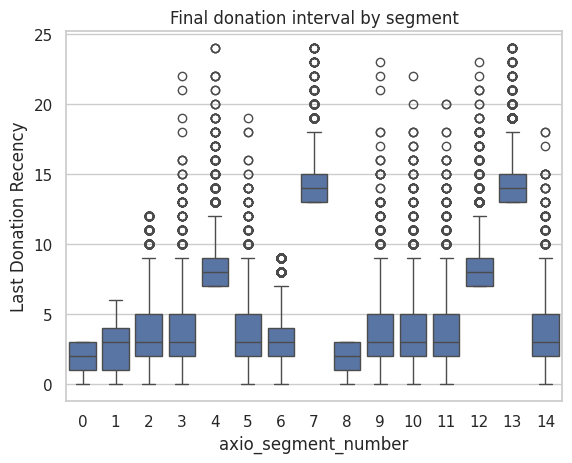

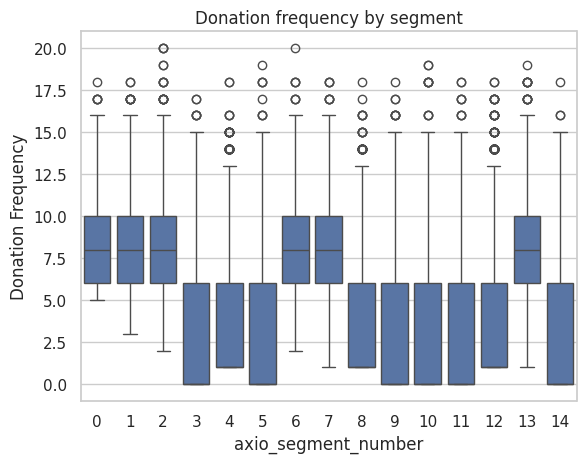

In [16]:
# Digital Engagement Score
sns.boxplot(x='axio_segment_number', y='Digital Engagement Score', data=df)
plt.title("Digital interaction scores by segment")
plt.show()

# The most recent donation.
sns.boxplot(x='axio_segment_number', y='Last Donation Recency', data=df)
plt.title("Final donation interval by segment")
plt.show()

# Frequency of donations
sns.boxplot(x='axio_segment_number', y='Donation Frequency', data=df)
plt.title("Donation frequency by segment")
plt.show()

# **Predictive Model (Classification)**

Predict the donor segmentation

In [17]:
# Choose the features（Exclude ID, Donation Amount Predicted and axio segment）
features = [
    'Donation Indicator', 'Donation Frequency', 'Average Donation',
    'Digital Engagement Score', 'Last Donation Recency',
    'Wealth Index', 'Event Participation'
]

In [18]:
X = df[features]
y = df['axio_segment_number']

# split to training and testing dataset (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# Build the model - RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1000
           1       0.94      1.00      0.97      1400
           2       0.96      1.00      0.98      2000
           3       0.58      0.64      0.61      1000
           4       0.99      0.99      0.99      1000
           5       0.91      0.93      0.92      1000
           6       0.97      1.00      0.98      1600
           7       0.99      0.99      0.99      1000
           8       1.00      0.77      0.87      1000
           9       0.92      0.84      0.87      1400
          10       0.90      0.91      0.91      2000
          11       0.86      0.89      0.88      1400
          12       1.00      1.00      1.00      1600
          13       0.99      1.00      1.00      1600
          14       0.88      0.82      0.85      1000

    accuracy                           0.93     20000
   macro avg       0.93      0.92      0.92     20000
weighted avg       0.93   

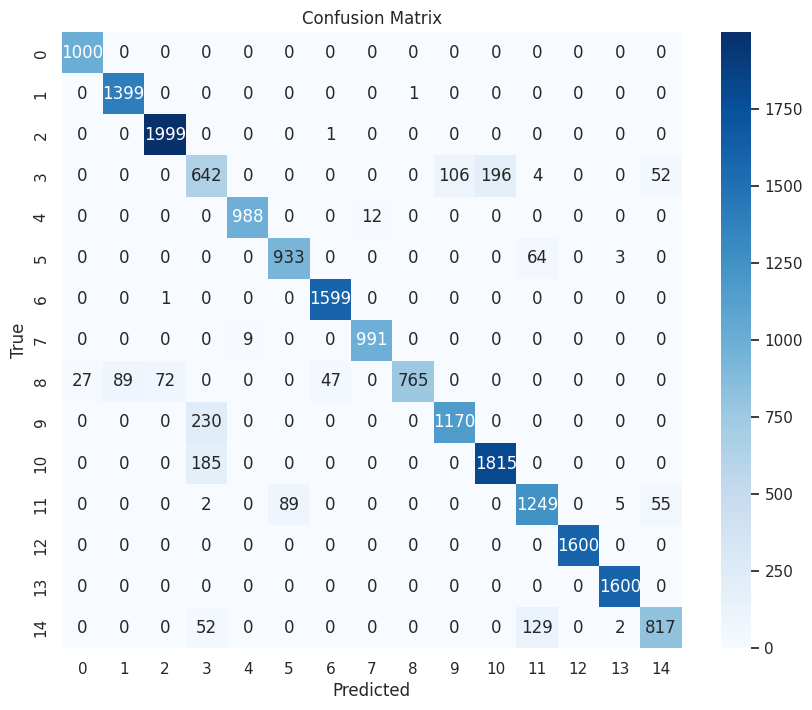

In [20]:
# Condusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

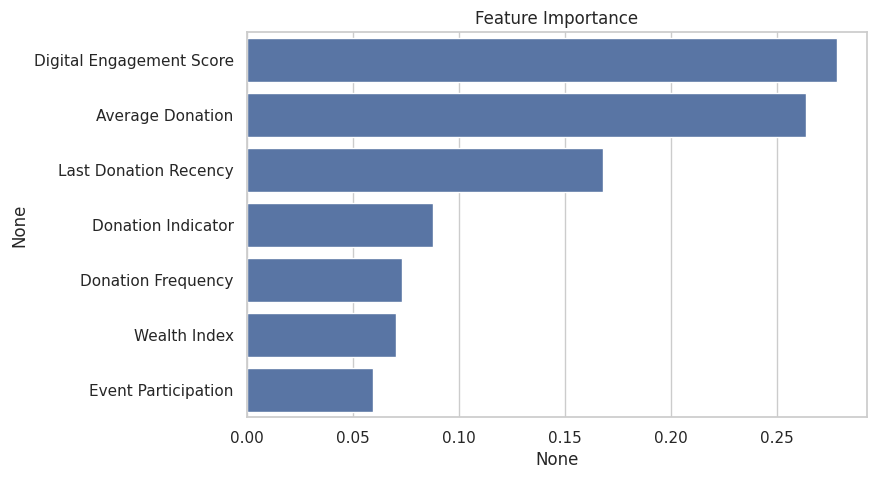

In [21]:
# feature importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance")
plt.show()

In [22]:
joblib.dump(rf, "donor_segment_model.pkl")

['donor_segment_model.pkl']

# **Predictive Model (Regression)**
Train a regression model to estimate how much each potential donor would contribute if they donate.

In this way, potential donors can be screened, resources can be concentrated on promotion, and marketing stratification according to the estimated amount to maximize ROI.


In [23]:
target = "Average Donation"
features = [
    'Donation Frequency',
    'Digital Engagement Score',
    'Last Donation Recency',
    'Wealth Index',
    'Event Participation'
]

# Avoid NaN
df_clean = df[features + [target]].dropna()
X = df_clean[features]
y = df_clean[target]

# # Build scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split to training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [24]:
# Build the model - RandomForest
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

In [25]:
# Predict
y_pred_rfr = rfr.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
r2 = r2_score(y_test, y_pred_rfr)
print("Random Forest - RMSE:", round(rmse, 2))
print("Random Forest - R² score:", round(r2, 4))

Random Forest - RMSE: 19.1
Random Forest - R² score: 0.9008


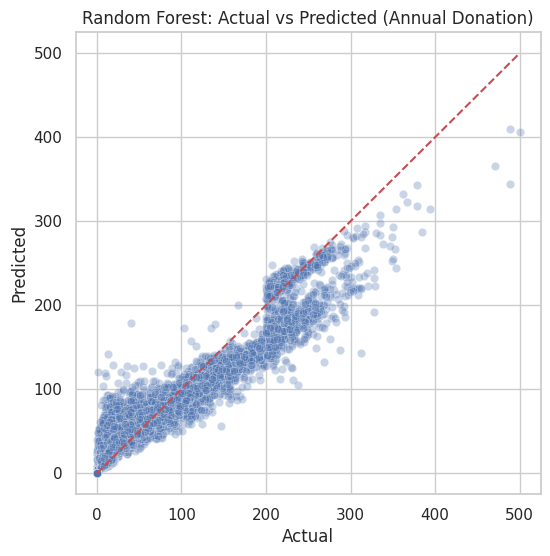

In [26]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_rfr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted (Annual Donation)")
plt.show()

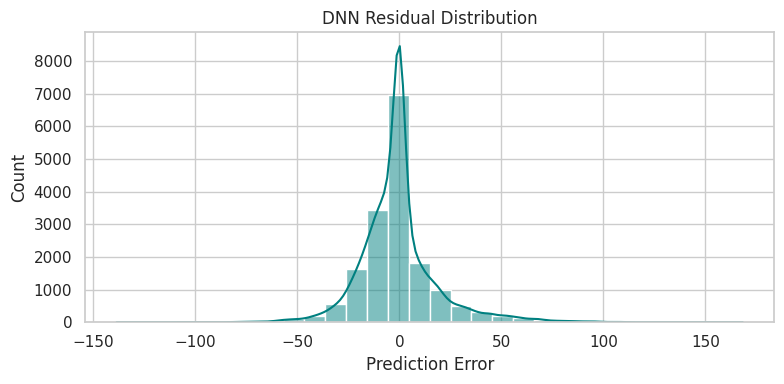

In [27]:
# Residual plot
residuals = y_test - y_pred_rfr
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30, color='teal')
plt.title("DNN Residual Distribution")
plt.xlabel("Prediction Error")
plt.tight_layout()
plt.show()

<Axes: xlabel='None', ylabel='None'>

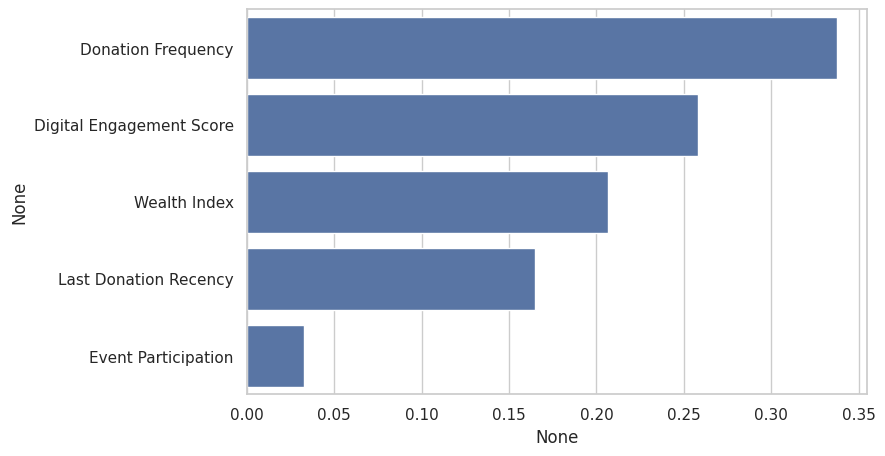

In [28]:
# Feature importnace
importances = pd.Series(rfr.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=importances.index)

In [29]:
# Interactive widgets to see the realtionship between deifferent features
frequency_slider = widgets.IntSlider(value=6, min=0, max=20, step=1, description='Frequency')
engagement_slider = widgets.IntSlider(value=70, min=0, max=100, step=1, description='Engagement')
recency_slider = widgets.IntSlider(value=2, min=0, max=24, step=1, description='Recency')
wealth_slider = widgets.IntSlider(value=70, min=0, max=100, step=1, description='Wealth Index')
event_slider = widgets.Dropdown(options={'None': 0,'Low': 1, 'Medium': 2, 'High': 3}, value=2, description='Event')

output = widgets.Output()

def predict_donation(change=None):
    input_data = pd.DataFrame([[
        frequency_slider.value,
        engagement_slider.value,
        recency_slider.value,
        wealth_slider.value,
        event_slider.value
    ]], columns=features)

    scaled_input = scaler.transform(input_data)
    prediction = rfr.predict(scaled_input)

    with output:
        output.clear_output()
        print(f"Predicted Donation Amount: ${prediction[0]:.2f}")

# Trigger prediction when any slider changes
for widget in [frequency_slider, engagement_slider, recency_slider, wealth_slider, event_slider]:
    widget.observe(predict_donation, names='value')

# Initial prediction
predict_donation()

ui = widgets.VBox([
    frequency_slider,
    engagement_slider,
    recency_slider,
    wealth_slider,
    event_slider,
    output
])
display(ui)

In [30]:
joblib.dump(rfr, "donation_amount_model.pkl")

['donation_amount_model.pkl']

# **Run The New Data**

In [31]:
segment_model = joblib.load("donor_segment_model.pkl")
amount_model = joblib.load("donation_amount_model.pkl")
def predict_segment(df, segment_model, amount_model, segment_map, strategy_map):
    # Preprocessing
    df['Donation Indicator'] = df['Donation Indicator'].map({True: 1, False: 0, 'TRUE': 1, 'FALSE': 0})
    df['Event Participation'] = df['Event Participation'].map({'None': 0, 'Low': 1, 'Medium': 2, 'High': 3})

    # Select model features
    X_columns_segment = [
        'Donation Indicator',
        'Donation Frequency',
        'Average Donation',
        'Digital Engagement Score',
        'Last Donation Recency',
        'Wealth Index',
        'Event Participation'
    ]
    X_segment = df[X_columns_segment]

    # Predict Segment
    df["Predicted_Segment"] = segment_model.predict(X_segment)
    df["Segment_Name"] = df["Predicted_Segment"].map(segment_map)

    # Select features for amount prediction
    X_columns_amount = [
        "Donation Frequency",
        "Digital Engagement Score",
        "Last Donation Recency",
        "Wealth Index",
        "Event Participation"
    ]
    X_amount = df[X_columns_amount]

    # Predict Donation Amount
    df["Donation Amount Predicted"] = amount_model.predict(X_amount).round(2)

    # Predict Strategy
    if strategy_map:
        df["Marketing_Strategy"] = df["Segment_Name"].map(strategy_map)
    return df

In [32]:
#### Run the new data ###
# If your data is in CSV format
new_data = pd.read_csv("new_donor_data.csv")  # Change to the actual file name or upload method
# If your data is in Excel format
# new_data = pd.read_excel("new_donor_data.excel")  # Change to the actual file name or upload method

### Predict the segment and add the segment column to the data ###
predicted_df = predict_segment(new_data, segment_model, amount_model, segment_map, strategy_map)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



Export the data with predicted donor segmentation, donation amount predicted, strategy map

In [33]:
# Export CSV (with the segment for the donor projection)
predicted_df.to_csv("Predicted_Donor_Segments.csv", index=False)
print("Prediction complete! A CSV file: Predicted_Donor_Segments.csv exported.")

# Export Excel (with the segment for the donor projection)
# predicted_df.to_excel("Predicted_Donor_Segments.xlsx", index=False)
# print("Prediction complete! An Excel file: Predicted_Donor_Segments.xlsx exported.")

Prediction complete! A CSV file: Predicted_Donor_Segments.csv exported.


# **Predicted Donor Segmentation & Donation Forecast Dashboard**

## Prediction Overview

In [35]:
predicted_df.head()

,Donation Indicator,Donation Frequency,Average Donation,Digital Engagement Score,Last Donation Recency,Donation Amount Predicted,Wealth Index,Event Participation,DonorID,Predicted_Segment,Segment_Name,Marketing_Strategy
0,1,9,117.82,84,1,105.18,78,2.0,0,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...
1,1,6,136.37,74,0,113.26,51,3.0,1,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...
2,1,7,118.78,72,2,82.86,77,3.0,2,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...
3,1,7,148.97,83,1,105.18,25,3.0,3,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...
4,1,6,118.62,87,2,82.86,72,2.0,4,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...


In [42]:
# Segment Distribution
segment_counts = predicted_df['Predicted_Segment'].value_counts().sort_index()
segment_counts

,count
Predicted_Segment,
0,5027
1,7088
2,10072
3,5245
4,4997
5,5022
6,8047
7,5003
8,4766


In [37]:
# Segment data
predicted_df["Total Donation"] = predicted_df["Average Donation"] * predicted_df["Donation Frequency"]
predicted_df["Donation Amount Predicted (Annual)"] = predicted_df["Donation Amount Predicted"] * predicted_df["Donation Frequency"]
predicted_df["Segment_Name"] = predicted_df["Predicted_Segment"].map(segment_map)
summary = predicted_df.groupby("Segment_Name").agg(
    Donor_Count=("DonorID", "count"),
    Total_Donation_This_Year=("Total Donation", "sum"),
    Total_Predicted_Donation_Next_Year=("Donation Amount Predicted (Annual)", "sum")).reset_index()

In [38]:
summary

,Segment_Name,Donor_Count,Total_Donation_This_Year,Total_Predicted_Donation_Next_Year
0,Digital-Engaged Non-Donors,8047,2532488.28,5771798.77
1,Engaged Mid-tier Donors,10072,1475151.20,7190438.61
2,Event-Only Non-Donors,4766,1003423.79,1264247.25
3,Fully Disengaged,4919,817718.34,1174409.68
4,High-Impact Infrequent Donors,8010,4135669.98,5584968.06
5,High-Potential Regulars,7088,4054519.02,5163969.89
6,Infrequent Low-Value Donors,6828,1143820.84,1639955.40
7,Interested Non-Donors,5003,2883087.09,3423526.45
8,Lapsed Donors,9930,1715807.77,2380919.71
9,Modest Donors,5245,873088.14,1246886.32


In [39]:
print("Total Predicted Donation Next Year After Marketing", summary['Total_Predicted_Donation_Next_Year'].sum())
print("Total Donation This Year", summary['Total_Donation_This_Year'].sum())

Total Predicted Donation Next Year After Marketing 45165797.77000001
Total Donation This Year 32883016.34


## Segment Distribution Dashboard

This dashboard provides a comparative visualization of donor segments based on:

1. Number of Donors:
  
  This shows the size of each segment in terms of donor count.

2. Total Predicted Donation Amount:
  
  This highlights the total contribution potential of each segment based on predicted donation amounts.

In [40]:
# Dashboard for visualization
fig = go.Figure()

# Pie: Segment Count
fig.add_trace(go.Pie(
    labels=summary["Segment_Name"],
    values=summary["Donor_Count"],
    title="Donor Count by Segment",
    domain={'x': [0, 0.48]},
    hole=0.4,
    marker=dict(colors=colors)
))

# Pie: Total Predicted Donation
fig.add_trace(go.Pie(
    labels=summary["Segment_Name"],
    values=summary["Total_Predicted_Donation_Next_Year"],
    title="Total Donation Potential by Segment",
    domain={'x': [0.52, 1]},
    hole=0.4,
    marker=dict(colors=colors)
))

fig.update_layout(
    title_text="Donor Segment Summary Dashboard",
    title_x=0.5,
    height=600
)

fig.show()

## Marketing Strategy Based On Donor Segmentation

In [57]:
# Summary of segment + strategy
strategy_df = predicted_df.groupby("Segment_Name").agg(
    Donor_Count=("DonorID", "count"),
    Avg_Predicted_Donation=("Donation Amount Predicted (Annual)", "mean")
).reset_index()
strategy_df["Strategy"] = strategy_df["Segment_Name"].map(strategy_map)

fig = px.scatter(strategy_df,x="Donor_Count",y="Avg_Predicted_Donation",
        color="Segment_Name",size="Avg_Predicted_Donation",
        hover_data=["Strategy"], title="Segment Strategy Mapping")
fig.show()

## High-Potential Segment Identification

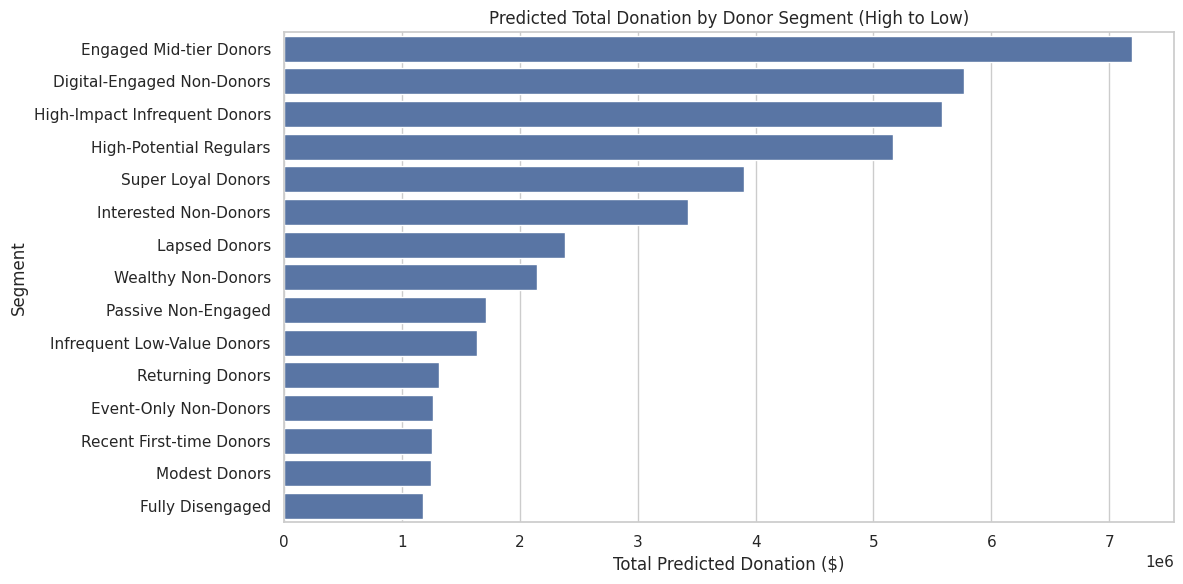

In [52]:
# Visualise the total predicted donations for each segment
plt.figure(figsize=(12, 6))
ordered_segments = summary.sort_values("Total_Predicted_Donation_Next_Year", ascending=False)["Segment_Name"]
sns.barplot(data=summary,x="Total_Predicted_Donation_Next_Year",y="Segment_Name",order=ordered_segments)
plt.xlabel("Total Predicted Donation ($)")
plt.ylabel("Segment")
plt.title("Predicted Total Donation by Donor Segment (High to Low)")
plt.tight_layout()
plt.show()

In [58]:
fig = px.scatter(summary,
        x="Donor_Count",
        y="Total_Predicted_Donation_Next_Year",
        color="Segment_Name",
        size="Total_Predicted_Donation_Next_Year",
        hover_name="Segment_Name",
        title="Donation Growth Opportunity Matrix")
fig.update_layout(xaxis_title="Donor Count",
        yaxis_title="Total Predicted Donation")
fig.show()

## High-Potential Donor Identification

In [55]:
# Export a list of high potentials (annual donation > $1000)
high_value_df = predicted_df[predicted_df["Donation Amount Predicted (Annual)"] > 1000]
high_value_df.head()

,Donation Indicator,Donation Frequency,Average Donation,Digital Engagement Score,Last Donation Recency,Donation Amount Predicted,Wealth Index,Event Participation,DonorID,Predicted_Segment,Segment_Name,Marketing_Strategy,Total Donation,Donation Amount Predicted (Annual),Predicted_Donation_Annual
12,1,13,104.20,98,2,82.86,86,3.0,12,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...,1354.60,1077.18,1077.18
26,1,11,140.38,82,1,105.18,44,3.0,26,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...,1544.18,1156.98,1156.98
32,1,12,121.04,77,1,105.18,49,3.0,32,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...,1452.48,1262.16,1262.16
34,1,10,143.21,96,1,105.18,75,3.0,34,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...,1432.10,1051.80,1051.80
37,1,12,119.66,78,1,105.18,48,3.0,37,0,Super Loyal Donors,Cultivate deeper relationships to sustain cont...,1435.92,1262.16,1262.16


In [76]:
# Export CSV
high_value_df.to_csv("High_Value_Donors_List.csv", index=False)
print(f"Exported {len(high_value_df)} high-potential donors to High_Value_Donors_List.csv")

Exported 7728 high-potential donors to High_Value_Donors_List.csv


## Non-donors with conversion potential

In [72]:
non_donors = predicted_df[predicted_df["Donation Indicator"] == 0]
converted = non_donors[non_donors["Donation Amount Predicted (Annual)"] > 0]

funnel = pd.DataFrame({
    "Stage": ["Non-Donors", "Predicted to Convert"],
    "Count": [len(non_donors), len(converted)]
})

fig = px.funnel(funnel, x="Count", y="Stage", title="Donor Conversion Funnel (Predicted)")
fig.show()

In [74]:
# Filter potential non-donors
potential_converts = predicted_df[
    (predicted_df["Donation Indicator"] == 0) &
    (predicted_df["Donation Amount Predicted (Annual)"] > 0)
].copy()

potential_converts = potential_converts.sort_values(
    by="Donation Amount Predicted", ascending=False
)

# Export to CSV
potential_converts.to_csv("Potential_Conversion_List.csv", index=False)
print(f"Exported {len(potential_converts)} potential donors to Potential_Conversion_List.csv")

Exported 21001 potential donors to Potential_Conversion_List.csv


## Target Comparison vs Goal

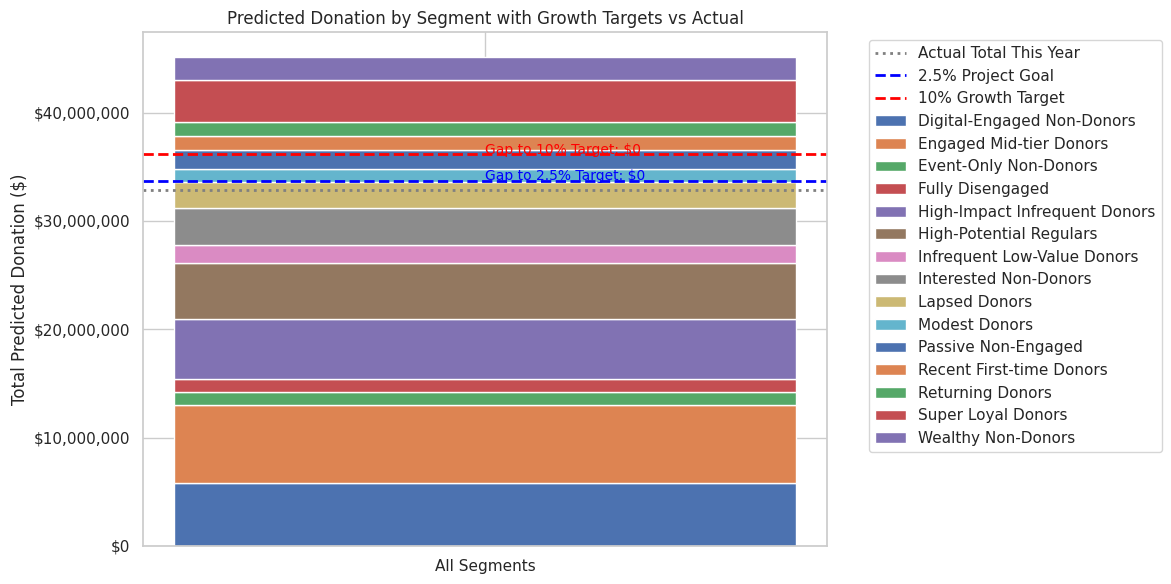

In [78]:
# Goal
Total_Donation_This_Year = summary['Total_Donation_This_Year'].sum()
project_target = Total_Donation_This_Year * 1.025
growth_target = Total_Donation_This_Year * 1.10

fig, ax = plt.subplots(figsize=(12, 6))
bottom = 0
for _, row in summary.iterrows():
    ax.bar("All Segments", row["Total_Predicted_Donation_Next_Year"], bottom=bottom, label=row["Segment_Name"])
    bottom += row["Total_Predicted_Donation_Next_Year"]

ax.axhline(y=Total_Donation_This_Year, color='gray', linestyle=':', linewidth=2, label='Actual Total This Year')
ax.axhline(y=project_target, color='blue', linestyle='--', linewidth=2, label='2.5% Project Goal')
ax.axhline(y=growth_target, color='red', linestyle='--', linewidth=2, label='10% Growth Target')

# Gap
gap_25 = max(project_target - summary["Total_Predicted_Donation_Next_Year"].sum(), 0) # Calculate gap using DataFrame column
gap_10 = max(growth_target - summary["Total_Predicted_Donation_Next_Year"].sum(), 0) # Calculate gap using DataFrame column

ax.text(0, project_target + 50000, f"Gap to 2.5% Target: ${gap_25:,.0f}", color='blue', fontsize=10)
ax.text(0, growth_target + 50000, f"Gap to 10% Target: ${gap_10:,.0f}", color='red', fontsize=10)
ax.set_ylabel("Total Predicted Donation ($)")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.set_title("Predicted Donation by Segment with Growth Targets vs Actual")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()